In [1]:
%matplotlib inline

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

from lmfit import Parameters, Minimizer, minimize, report_fit

import scqubits as scq

scq.settings.FUZZY_SLICING = True

In [3]:
osc = scq.Oscillator(E_osc = 1)
gq = scq.GenericQubit(E = 1)

g = 0.1
hilbertspace = scq.HilbertSpace([gq, osc])

hilbertspace.add_interaction(
    g_strength = g,
    op1 = osc.annihilation_operator,
    op2 = gq.sp_operator,
    add_hc = True
)

In [4]:
dressed_hamiltonian = hilbertspace.hamiltonian()
evals, evecs = hilbertspace.eigensys(evals_count=12)

print(hilbertspace, dressed_hamiltonian, evals, evecs)

HilbertSpace:  subsystems
-------------------------

GenericQubit--------|
                    | E: 1
                    |
                    | dim: 2


Oscillator----------|
                    | E_osc: 1
                    | l_osc: None
                    | truncated_dim: 6
                    |
                    | dim: 6



HilbertSpace:  interaction terms
--------------------------------

InteractionTerm----------|
                         | g_strength: 0.1
                         | operator_list: [(1, array([[0.        , 1.        , 0.        , 0 ...
                         | add_hc: True

 Quantum object: dims = [[2, 6], [2, 6]], shape = (12, 12), type = oper, isherm = True
Qobj data =
[[-0.5         0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.5         0.          0.          0.          0.
   0.1         0.          0.          0.          0.          0.        ]
 [ 0.    

In [5]:
pname1 = 'E'
E_vals = np.linspace(0.0, 10.0, 101)
#pname2 = 'E_osc'
#E_osc_vals = np.linspace(0.0, 10.0, 101)
pname3 = 'detuning'
detuning_vals = np.linspace(0.0, 10.0, 101)


#paramvals_by_name = {pname1: E_vals, pname2: E_osc_vals, pname3: detuning_vals}
paramvals_by_name = {pname1: E_vals, pname3: detuning_vals}

#def update_hilbertspace(E, E_osc, detuning):
#    gq.E = E
#    osc.E_osc = E_osc

def update_hilbertspace(E, detuning):
    gq.E = E
    osc.E_osc = E + detuning
    
sweep = scq.ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=3,
    num_cpus=4
)

Parallel compute bare eigensys [num_cpus=4]

Parallel compute bare eigensys [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

In [6]:
sweep["evals"][0, :]

NamedSlotsNdarray([[-2.23606798e-01, -2.00000000e-01, -1.73205081e-01],
                   [-6.18033989e-02, -2.11432593e-17,  0.00000000e+00],
                   [-4.14213562e-02,  0.00000000e+00,  1.26794919e-01],
                   [-3.02775638e-02,  0.00000000e+00,  2.43844719e-01],
                   [-2.36067977e-02,  0.00000000e+00,  3.55051026e-01],
                   [-1.92582404e-02,  0.00000000e+00,  4.62771868e-01],
                   [-1.62277660e-02,  0.00000000e+00,  5.68337521e-01],
                   [-1.40054945e-02,  0.00000000e+00,  6.72508278e-01],
                   [-1.23105626e-02,  0.00000000e+00,  7.75735931e-01],
                   [-1.09772229e-02,  0.00000000e+00,  8.78300943e-01],
                   [-9.90195136e-03,  0.00000000e+00,  9.80384758e-01],
                   [-9.01699437e-03,  0.00000000e+00,  1.08210917e+00],
                   [-8.27625303e-03,  0.00000000e+00,  1.18355860e+00],
                   [-7.64732190e-03,  0.00000000e+00,  1.2847932

(<Figure size 900x600 with 1 Axes>, <AxesSubplot:xlabel='detuning'>)

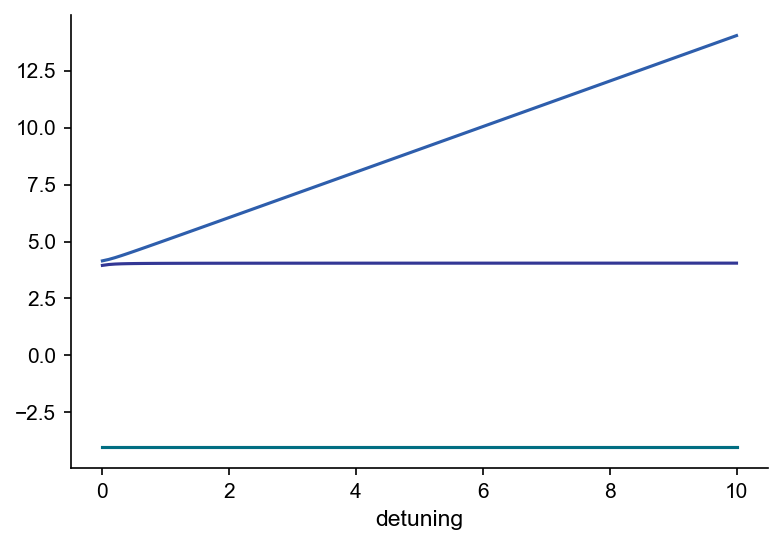

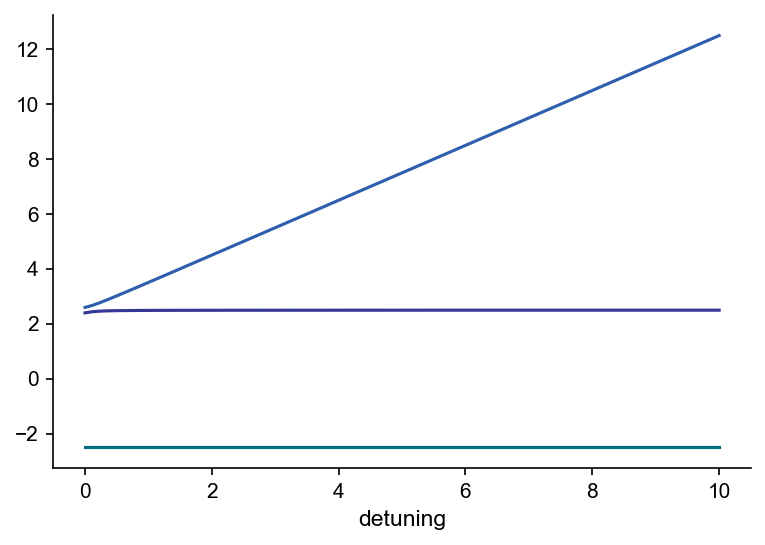

In [7]:
sweep["evals"][8.1, :].plot()
sweep["evals"][5.0, :].plot()

In [11]:
def update_hilbertspace(E, detuning):
    gq.E = E
    osc.E_osc = E + detuning

x = np.linspace(0, 10, 101)

pname1 = 'E'
E_vals = x
pname3 = 'detuning'
detuning_vals = x

paramvals_by_name = {pname1: E_vals, pname3: detuning_vals}

sweep = scq.ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=3,
    num_cpus=4
)

Parallel compute bare eigensys [num_cpus=4]

Parallel compute bare eigensys [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

In [12]:
def jc_resid(pars, x, data=None):
    e = pars['e']
    
    y = sweep["evals"][float(e), :]
    model = interpolate.interp1d(x, y)
    if data is None:
        return model
    #return model - data
    resid = model - data
    return resid.flatten()

params = Parameters()
params.add('e', value=3.8, min = 0, max = 10)

e = 8.1
y = interpolate.interp1d(x, sweep["evals"][float(e), :])
data = y + 0.25*np.random.normal(size=y.shape)

min1 = Minimizer(jc_resid, params, fcn_args=(x,), fcn_kws={'data': data})
out1 = min1.leastsq()
fit1 = jc_resid(out1.params, x)
report_fit(out1.params)

out2 = minimize(jc_resid, params, method = 'brute', args=(x, data))
fit2 = jc_resid(out2.params, x)
report_fit(out2.params)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [39]:
print(type(y))


<class 'numpy.ndarray'>


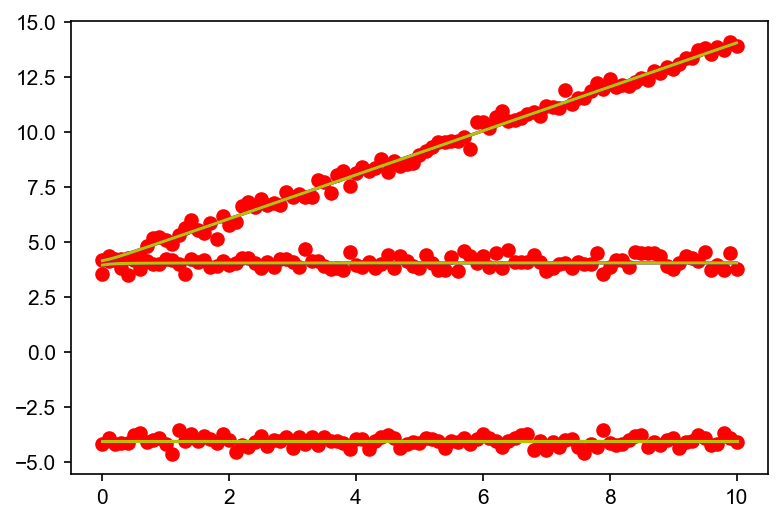

In [36]:
plt.plot(x, data, 'ro')
plt.plot(x, fit1, 'b')
plt.plot(x, fit2, 'y')
plt.show()